In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer

### The Movie Database

- Algorithms of recommendations :

Demographic Filtering make the same recommendation to every user, based on movie popularity and/or genre. The trending list you see in YouTube or Netflix are based on this system. <br>
The idea of this system is that popular and critically acclaimed movies have a higher probability of being liked by the average audience.

Content Based Filtering takes a movie that a user currently likes as input, then it analyzes its contents (storyline, genre, cast, director) to find out other movies which have similar content. <br>
The intuition is that if a person liked a particular item, he or she will also like an item that is similar to it.

Collaborative Filtering : matches persons with similar interests and provides recommendations based on this matching. 
The “Customers who viewed this item also viewed” section on Amazon is an example of use of this algorithm. 

- Dataset

The data used for this project are available at this link : https://www.kaggle.com/tmdb/tmdb-movie-metadata
This table gathers 4803 movies and contain many features related to the films such as language, title, average score, year of release, cast ...

In [2]:
# Gather datasets
df_credit = pd.read_csv('tmdb_5000_credits.csv')
df_credit.rename(columns={'movie_id':'id'}, inplace=True)

df_movies = pd.read_csv('tmdb_5000_movies.csv')

# Join the databases on the id column
df = df_movies.merge(df_credit, on='id')

# Drop useless columns
df.drop(columns=['title_x'], inplace=True)
df.rename(columns={'title_y':'title'}, inplace=True)

df.drop(columns=['status'], inplace=True)

df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [3]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'title',
       'cast', 'crew'],
      dtype='object')

### Demographic filtering system

   1) Define a metrics to rank the movies, <br>
   2) Compute the score of each film, <br>
   3) Sort the movies according to this score and recommend the highest to the user.

We could use the vote average as scoring metrics, but it could be biased for movies with very few recommendations (10% of our movies get less than 12 votes). 

Instead, we can use a weighting average computed by IMDb ('vote_average' column), computed as follow :

<img src = "IMDb rating average.png" width="400" height="200">

Source : https://en.wikipedia.org/wiki/IMDb#Rankings

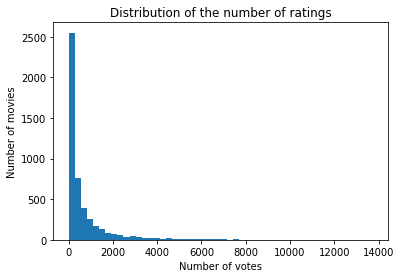

In [4]:
# Distribution of the number of votes
plt.hist(df.vote_count, bins=50)

plt.ylabel('Number of movies')
plt.xlabel('Number of votes')
plt.title('Distribution of the number of ratings');

In [5]:
# Movies scores statistics
C = df.vote_average.mean()
print('Average rating : ', round(C, 2), '/10')

m = df.vote_count.quantile(0.9)
print('90th percentile of number of ratings : ', int(m))

Average rating :  6.09 /10
90th percentile of number of ratings :  1838


As we only look for very popular movies, we'll only consider recommending those getting more than 1838 votes.
By definition, 481 movies qualify to enter this list (10% of the whole population). 
The we'll compute the average rating for those movies

In [6]:
# Select only famous movies
df_fame = df.loc[df['vote_count'] > df['vote_count'].quantile(0.9)]

print('Average number of ratings of the most famous movies : ', 
      round(df_fame.vote_count.mean()))

Average number of ratings of the most famous movies :  3684


In [7]:
# Weighted score based on IMDb formula

def Weighted_Rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    
    return (R*v + C*m) / (v+m)

In [8]:
# Compute each movie's score
df_fame['IMDb_Score'] = df_fame.apply(Weighted_Rating, axis=1)

print("Top 10 movies")
# Select and order top 10 movies by weighted score
top_scores = df_fame[['title', 'vote_count', 'IMDb_Score']].sort_values(by='IMDb_Score', ascending=False)

display(top_scores.iloc[:10, :])

Top 10 movies


C:\Users\jguer_gompqqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,vote_count,IMDb_Score
1881,The Shawshank Redemption,8205,8.059258
662,Fight Club,9413,7.939256
65,The Dark Knight,12002,7.920020
3232,Pulp Fiction,8428,7.904645
96,Inception,13752,7.863239
3337,The Godfather,5893,7.851236
95,Interstellar,10867,7.809479
809,Forrest Gump,7927,7.803188
329,The Lord of the Rings: The Return of the King,8064,7.727243
1990,The Empire Strikes Back,5879,7.697884


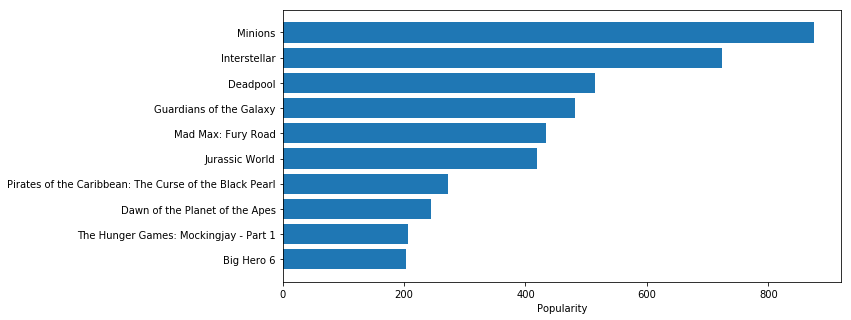

In [9]:
# 10 most popular movies
df_pop = df_fame.sort_values(by='popularity', ascending=False)

plt.figure(figsize=(10, 5))

# Horizontal plot
plt.barh(df_pop['title'].head(10), 
         df_pop['popularity'].head(10), align='center')

plt.gca().invert_yaxis()
plt.xlabel('Popularity');

### Movie descirption-based algorithm

In suh algorithm we use the characteristics and the features of each movie (the content), to find similar movies for the user. The movies most likely to be similar to those the user ranked highly are then recommended.

First, we'll compute pairwise similarity between each movie, based on their description. 

In [10]:
# Example of a movie description
print('Overview of Avatar')
df.loc[:, 'overview'][0]

Overview of Avatar


'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

To begin, let's compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each description. In reflect how important a word is in a document and in a corpus of texts. <br>

Term Frequency is the frequency of apparition of a word in a text (term occurence / total occurences).<br>
Inverse Document Frequency measures how important a word is (log(number of docs / docs with term)). The idea is that word present in many texts (e.g. 'the', 'in', 'for') doesn't provide much insight. 

The importanc of each word is computed with TF * IDF. 

The TF-IDF is a matrix containing a word in each column, and a movie for each row.

In [11]:
# Create a Tfidf vector object and remove english stop-words (the, a, in ...)
tfidf = TfidfVectorizer(stop_words='english')

# Replace Nan with empty string
df['overview'].fillna('', inplace=True)

tfidf_matrix = tfidf.fit_transform(df['overview'])

In [12]:
print(tfidf_matrix.shape[1], 'words were used to describe the', 
      tfidf_matrix.shape[0], 'movies of our dataset.')

20978 words were used to describe the 4803 movies of our dataset.


We can now compute the similarity between each of our movies. We can use various statistical methods to measure the similarity between two movies : euclidian, Person, cosine.

In [13]:
cosine_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

Now we want to create a function that input a movie and show the 10 most similar ones of the dataset.

In [14]:
# Create a reverse map of movies titles and indices
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
indices[:5]

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

In [15]:
def Get_Recommendations(title, cosine_similarity=cosine_similarity):
    # Get the index of the movie
    index = indices[title]
    
    # Get pairwise similarity of all movies
    similarity = list(enumerate(cosine_similarity[index]))
    similarity = sorted(similarity, key = lambda x : x[1], reverse=True)
    
    # Get top 10
    similarity = similarity[1:11]
    
    # Get their index and return name
    movies_idx = [i[0] for i in similarity]
    
    return df['title'].iloc[movies_idx]

In [16]:
Get_Recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [17]:
Get_Recommendations('Jurassic Park')

28                   Jurassic World
2527    National Lampoon's Vacation
1580                    The Nut Job
479          Walking With Dinosaurs
2805           The Land Before Time
1983               Meet the Deedles
3577               The Way Way Back
54                The Good Dinosaur
3139                  Adventureland
1536                       Vacation
Name: title, dtype: object

As we can see, using only the movie description in our recommendation algorithm can lead to results lacking pertinence (e.g. 'The Good Dinosaur' when we input 'Jurassic Park'). Indeed, the model only have a few lines describing the movie, and thus the keyword carry a very large weight in our recommendation.

To adress this issue, we'll use more relevant features to build our recommendation machine. 

### Credit, Genre and Keyword based recommendation

We'll base our algorithm on 3 key features for a movie : the director, the main actors, the genre of the movie and the plot.

In [18]:
# Parse the stringified features into their corresponding python objects
features = ['genres', 'keywords', 'cast', 'crew']

for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [19]:
# Get the director name
def get_director(movie):
    for i in movie:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Get top 3 elements for actors, genre, keyword, spoken_languages
def get_list(movie):
    if isinstance(movie, list):
        names = [i['name'] for i in movie]
        
        if len(names) > 3 :
            names = names[:3]
        return names
    
    return []

In [20]:
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features :
    df[feature] = df[feature].apply(get_list)

In [21]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [22]:
# Clean the features to have it as undercase, without space in names
def clean_data(movie):
    if isinstance(movie, list):
        return [str.lower(i.replace(" ", "")) for i in movie]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(movie, str):
            return str.lower(movie.replace(" ", ""))
        else:
            return ''

In [23]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)
    
df[features].head(2)

,cast,keywords,director,genres
0,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]",jamescameron,"[action, adventure, fantasy]"
1,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]",goreverbinski,"[adventure, fantasy, action]"


In [24]:
# I MODEIFIED THE JOIN HERE
def Describe(movie):
    return ' '.join(movie['keywords']) + ' ' + ' '.join(movie['cast']) + ' ' + movie['director'] + ' ' + ' '.join(movie['genres'])

df['description'] = df.apply(Describe, axis=1)

In [25]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['description'])

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])

In [26]:
Get_Recommendations('The Dark Knight Rises', cosine_sim)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [27]:
Get_Recommendations('The Godfather', cosine_sim)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [28]:
Get_Recommendations('Jurassic Park', cosine_sim)

508     The Lost World: Jurassic Park
334                 Jurassic Park III
91       Independence Day: Resurgence
28                     Jurassic World
185                 War of the Worlds
507                  Independence Day
2967       E.T. the Extra-Terrestrial
363      A.I. Artificial Intelligence
83                         The Lovers
193                       After Earth
Name: title, dtype: object